# Problem Statement

## Business Context

In the competitive landscape of retail banking, customer retention is critical for ensuring sustainable growth and profitability. A prominent retail banking institution in Europe provides a range of financial products, including credit cards, loans, and savings accounts, and has been rapidly expanding its customer base across multiple countries. However, with a growing customer base, it faces an increasingly pressing challenge: customer churn. A significant number of customers are closing their accounts and switching to competitors. This decline in customer retention is impacting revenue and long-term customer relationships

Understanding the reasons behind customer attrition (or churn) is essential for the bank to devise effective retention strategies to minimize churn and enhance customer loyalty and satisfaction. The Customer Analytics & Retention Department has been diligently collecting and analyzing historical customer data. Despite the valuable insights provided by historical data, the department grapples with several challenges:

1. **Complex Customer Behavior**: The diverse nature of the bank's offerings and the varying customer preferences across different countries complicate the identification of factors that lead to churn.
2. **Proactive Retention**: The current processes for identifying at-risk customers are reactive rather than proactive, leading to missed opportunities for timely interventions that could prevent churn.

## Objective

The Customer Analytics & Retention Department has successfully developed a machine learning model that identifies patterns indicative of churn risk and predicts the likelihood of customer churn. They recognize the potential of this model to significantly contribute to reducing churn rates by identifying at-risk customers before they decide to leave.

However, to harness the value of this model, the team seeks to deploy it as a web application to allow for broader use across departments, enabling customer service representatives, marketing teams, and management to access churn predictions in real time. The primary objective is to create an intuitive web app with the ML model under the hood to identify customers at risk of churn. The successful deployment of this web application will facilitate timely interventions, improve customer retention strategies, and ultimately work towards enhancing customer satisfaction and loyalty.

## Data Dictionary

- **CustomerId**: Unique identifier for each customer.  
- **Surname**: Customer's last name.  
- **CreditScore**: Customer's credit score.  
- **Geography**: Country where the customer resides.   
- **Age**: Customer's age in years.  
- **Tenure**: Number of years the customer has been with the bank.  
- **Balance**: Customer’s account balance.  
- **NumOfProducts**: Number of products the customer has with the bank.  
- **HasCrCard**: Indicates if the customer has a credit card (1 = Yes, 0 = No).  
- **IsActiveMember**: Indicates if the customer is an active member (1 = Yes, 0 = No).  
- **EstimatedSalary**: Customer’s estimated salary.  
- **Exited**: Indicates whether the customer churned (1 = Yes, 0 = No).  

# Installing and Importing Necessary Libraries

In [ ]:
!pip install pandas==2.2.2 numpy==2.0.2 scikit-learn==1.6.1 xgboost==2.1.4 joblib==1.4.2 streamlit==1.43.2 huggingface_hub==0.29.3 -q

In [ ]:
# for data manipulation
import pandas as pd

import sklearn

# for data preprocessing and pipeline creation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# for model training, tuning, and evaluation
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, recall_score

# for model serialization
import joblib

# for creating a folder
import os

# for hugging face space authentication to upload files
from huggingface_hub import login, HfApi

In [ ]:
# Set scikit-learn's display mode to 'diagram' for better visualization of pipelines and estimators
sklearn.set_config(display='diagram')

# Data Loading and Overview

In [ ]:
# Load the dataset from a CSV file into a Pandas DataFrame
bank_churn = pd.read_csv("bank_customer_churn.csv")

In [ ]:
# Create a copy of the dataframe
dataset = bank_churn.copy()

In [ ]:
# Display the first five rows of the dataset
dataset.head()

,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,Hill,608,Spain,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,Onio,502,France,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,Boni,699,France,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,Mitchell,850,Spain,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [ ]:
# Display the number of rows and columns in the dataset
dataset.shape

(10002, 12)

In [ ]:
# Display the column names of the dataset
dataset.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

# EDA

Let's start by defining the target and predictor (numerical and categorical) variables.

- We'll not consider the `CustomerId` and `Surname` attributed as they don't add value to the analysis and consequent modeling.

- Although the `HasCrCard` and `IsActiveMember` attributes are categorical (binary), we'll consider them as numerical as they're already encoded.

In [ ]:
# Define the target variable for the classification task
target = 'Exited'

# List of numerical features in the dataset
numeric_features = [
    'CreditScore',       # Customer's credit score
    'Age',               # Customer's age
    'Tenure',            # Number of years the customer has been with the bank
    'Balance',           # Customer’s account balance
    'NumOfProducts',     # Number of products the customer has with the bank
    'HasCrCard',         # Whether the customer has a credit card (binary: 0 or 1)
    'IsActiveMember',    # Whether the customer is an active member (binary: 0 or 1)
    'EstimatedSalary'    # Customer’s estimated salary
]

# List of categorical features in the dataset
categorical_features = [
    'Geography',         # Country where the customer resides
]

In [ ]:
# Generate summary statistics for numerical features
dataset[numeric_features].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10002.000000,10001.000000,10002.000000,10002.000000,10002.000000,10001.000000,10001.000000,10002.000000
mean,650.555089,38.922311,5.012498,76491.112875,1.530194,0.705529,0.514949,100083.331145
std,96.661615,10.487200,2.891973,62393.474144,0.581639,0.455827,0.499801,57508.117802
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50983.750000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100185.240000
75%,718.000000,44.000000,7.000000,127647.840000,2.000000,1.000000,1.000000,149383.652500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


1. **Balance Distribution:**
   - The mean balance is **~76,491**, but the **25th percentile is 0**, indicating that **at least 25% of customers have a balance of zero**.
   - Possible explanations:
     - Customers may use the account primarily for transactions, withdrawing funds immediately after deposits.
     - Some customers might have secondary accounts with zero balance.
     - Certain customers may have no savings account but only hold credit cards.

2. **Age and Credit Score:**
   - The average age is **~39 years**, with a max of **92 years**.
   - The credit score ranges from **350 to 850**, with an average of **650**.

3. **Products and Activity:**
   - Most customers have **1 or 2 products** (median = 1).
   - Around **70% have a credit card**, and **51% are active members**.

4. **Churn Rate:**
   - The **Exited (churn) rate is ~20%**, meaning **1 in 5 customers leave** the bank.


In [ ]:
dataset[categorical_features].describe()

,Geography
count,10001
unique,3
top,France
freq,5014


In [ ]:
# Compute the proportion of each class in the target variable
dataset[target].value_counts(normalize=True)

,proportion
Exited,
0,0.796241
1,0.203759


Dataset contains **10002** total records with the following distribution:  

- **79.6% customers did not churn (No)**  
- **20.3% customers churned (Yes)**  

This means the dataset is **imbalanced**

### Why does this matter?

- A model trained on this data **may be biased towards predicting "No" (non-churn)** because it is the majority class.  
- Standard classification models might achieve **high accuracy but low recall for churners**, meaning they fail to detect many actual churn cases.

### What can be done?

1. **Resampling techniques**:  
   - **Oversampling (SMOTE)**: Generate synthetic churn cases to balance the dataset.  
   - **Undersampling**: Remove some "No" cases to balance the dataset.  

2. **Adjust `scale_pos_weight` in XGBoost**:  
   - Set `scale_pos_weight = 5174 / 1869 ≈ 2.77` to give more importance to the minority class (churn).  

3. **Optimize for recall instead of accuracy**:  
   - Since churn prediction is a critical business problem, a high recall ensures fewer actual churners are missed.

# Model Training with Hyperparameter Tuning

## Data Preprocessing

In [ ]:
# Define predictor matrix (X) using selected numeric and categorical features
X = dataset[numeric_features + categorical_features]

# Define target variable
y = dataset[target]

In [ ]:
# Split the dataset into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,              # Predictors (X) and target variable (y)
    test_size=0.2,     # 20% of the data is reserved for testing
    random_state=42    # Ensures reproducibility by setting a fixed random seed
)

In [ ]:
# Create a preprocessing pipeline for numerical and categorical features
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),  # Scale numeric features to have mean equal to 0 and standard deviation equal to 1
    (OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical features as one-hot vectors
)

- The **`make_column_transformer`** step creates a preprocessing pipeline for your dataset by applying different transformations to numeric and categorical features.

### **Breakdown:**

1. **`StandardScaler()` for numeric features**  
   - Scales numerical columns (`tenure`, `MonthlyCharges`, `TotalCharges`, `SeniorCitizen`) to have **zero mean and unit variance**.  
   - This helps ML models handle features with different scales effectively.

2. **`OneHotEncoder()` for categorical features**  
   - Converts categorical columns (`Contract`, `PaperlessBilling`, `PaymentMethod`, etc.) into **one-hot encoded vectors**.  

### **Why is this important?**

- **Ensures proper feature scaling** (for better model performance).  
- **Encodes categorical variables** into a machine-readable format.  
- **Prepares data for ML models** that require numerical inputs.

## Creating Model Pipeline

In [ ]:
# Initialize an XGBoost classifier
model_xgb = xgb.XGBClassifier(random_state=42)

In [ ]:
# Create a machine learning pipeline with preprocessing and model training steps
model_pipeline = make_pipeline(
    preprocessor,  # Preprocesses numerical and categorical features
    model_xgb      # XGBoost classifier for model training
)

This creates a pipeline that

- **first preprocesses the data** (scaling numeric features and encoding categorical ones), and
- **then trains** the XGBoost **model**.

It ensures that **all transformations are applied automatically before feeding the data into the model**.

## Model Training

In [ ]:
# Train the model pipeline on the training data
model_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbac...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Make predictions on the training data
y_pred_train = model_pipeline.predict(Xtrain)

# Make predictions on the test data
y_pred_test = model_pipeline.predict(Xtest)

In [ ]:
# Generate a classification report to evaluate model performance on training set
print(classification_report(ytrain, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6365
           1       0.97      0.81      0.88      1636

    accuracy                           0.96      8001
   macro avg       0.96      0.90      0.93      8001
weighted avg       0.96      0.96      0.95      8001



In [ ]:
# Generate a classification report to evaluate model performance on test set
print(classification_report(ytest, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.91      1599
           1       0.71      0.52      0.60       402

    accuracy                           0.86      2001
   macro avg       0.80      0.73      0.76      2001
weighted avg       0.85      0.86      0.85      2001



- While the model can identify non-churners well, it fails to do the same for customers who will churn.
    - Since the number of customers who churn is much lower, the model fails to identify the associated patterns.
    - We'll handle this by assigning weights to the different classes using the `scale_pos_weight` parameter of the XGBoost model.
- The model overfits the training data, as the training and test recall for customers who churn differ by 30%.
    - We'll handle this via hyperparameter tuning.

## Hyperparameter Tuning

In [ ]:
# Set the clas weight to handle class imbalance
class_weight = ytrain.value_counts()[0] / ytrain.value_counts()[1]
class_weight

np.float64(3.890586797066015)

In [ ]:
# Define the preprocessing steps
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features)
)

In [ ]:
# Define base XGBoost model
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weight, random_state=42)

# Define hyperparameter grid
param_grid = {
    'xgbclassifier__n_estimators': [50, 100, 150, 200],    # number of tree to build
    'xgbclassifier__max_depth': [2, 3, 4],    # maximum depth of each tree
    'xgbclassifier__colsample_bytree': [0.4, 0.5, 0.6],    # percentage of attributes to be considered (randomly) for each tree
    'xgbclassifier__colsample_bylevel': [0.4, 0.5, 0.6],    # percentage of attributes to be considered (randomly) for each level of a tree
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],    # learning rate
    'xgbclassifier__reg_lambda': [0.4, 0.5, 0.6],    # L2 regularization factor
}

The following code, which includes model pipeline creation and hyperparameter tuning using GridSearchCV, will take approximately 10-15 minutes to complete. Please allow sufficient time for execution.

In [ ]:
# Model pipeline
model_pipeline = make_pipeline(preprocessor, xgb_model)

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Geography'])])),
                                       ('xgbclassifier',
                                        XGBClassifier(base_sco...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__colsample_bylevel': [0.4, 0.5, 0.6],
                         'xgbclassifier__colsample_bytree': [0.4, 0.5, 0.6],
                         'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
                         'xgbclassifier__max_depth': [2, 3, 4],
                         'xgbclassifier__n_estimators': [50, 100, 150, 200],
                         'xgbclassifier__reg_lambda': [0.4, 0.5, 0.6]})

## Selecting the Best Model

In [ ]:
# Check the parameters of the best model
grid_search.best_params_

{'xgbclassifier__colsample_bylevel': 0.4,
 'xgbclassifier__colsample_bytree': 0.5,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__n_estimators': 200,
 'xgbclassifier__reg_lambda': 0.5}

In [ ]:
# Store the best model
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbac...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

The classification threshold is important because it controls precision and recall trade-offs.
- Since customer churn prediction is a retention problem, a higher recall is preferred. We want to correctly identify as many churners as possible, even if it means getting some false positives.
- We'll lower the classification threshold to 0.45 from 0.5 to increase the recall.

In [ ]:
# Set the classification threshold
classification_threshold = 0.45

In [ ]:
# Make predictions on the training data
y_pred_train_proba = best_model.predict_proba(Xtrain)[:, 1]
y_pred_train = (y_pred_train_proba >= classification_threshold).astype(int)

# Make predictions on the test data
y_pred_test_proba = best_model.predict_proba(Xtest)[:, 1]
y_pred_test = (y_pred_test_proba >= classification_threshold).astype(int)

In [ ]:
# Generate a classification report to evaluate model performance on training set
print(classification_report(ytrain, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      6365
           1       0.52      0.84      0.64      1636

    accuracy                           0.81      8001
   macro avg       0.74      0.82      0.76      8001
weighted avg       0.86      0.81      0.82      8001



In [ ]:
# Generate a classification report to evaluate model performance on test set
print(classification_report(ytest, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1599
           1       0.48      0.78      0.59       402

    accuracy                           0.78      2001
   macro avg       0.71      0.78      0.72      2001
weighted avg       0.84      0.78      0.80      2001



- We can see that the **overfitting has significantly reduced**.
- The **test set recall for the class corresponding to churn** has also **significantly improved** (by ~25%) to 78%.
- As expected, while recall has improved, precision has dropped.

We'll go ahead with this model as our final model.

# Model Serialization

In [ ]:
# Create a folder for storing the files needed for web app deployment
os.makedirs("deployment_files", exist_ok=True)

In [ ]:
# Define the file path to save (serialize) the trained model along with the data preprocessing steps
saved_model_path = "deployment_files/churn_prediction_model_v1_0.joblib"

# Save the trained model pipeline using joblib
joblib.dump(best_model, saved_model_path)

['deployment_files/churn_prediction_model_v1_0.joblib']

This code is used to save a trained machine learning model pipeline using `joblib`, which is a library for efficient object serialization in Python.

**Breakdown:**  
1. **`saved_model_path = "churn_prediction_model_v1_0.joblib"`**  
   - Defines the file path where the model will be saved.  
   - The model will be stored as a `.joblib` file, a format optimized for large NumPy arrays and machine learning models.  
   - The last part of the filename (`v1_0`) specifies a version number, which is a good practice to track changes and maintain multiple model iterations

2. **`joblib.dump(model_pipeline, saved_model_path)`**  
   - Saves the trained `model_pipeline` object to the specified path (`model.joblib`).  
   - `joblib.dump()` is preferred over `pickle.dump()` for saving large models because it is faster and more efficient with numerical data.  
   - The saved file can be loaded later using `joblib.load("model.joblib")` for inference or further training.  

This approach ensures that the model pipeline, including preprocessing steps and the trained model, is preserved for later use.

In [ ]:
# Load the saved model pipeline from the file
saved_model = joblib.load("deployment_files/churn_prediction_model_v1_0.joblib")

1. **`joblib.load("churn_prediction_model_v1_0.joblib")`**  
   - Loads the previously saved machine learning model (or pipeline) from the `model.joblib` file.  
   - The model retains all trained parameters, including preprocessing steps and learned patterns.

2. **`saved_model`**  
   - This variable stores the deserialized model, allowing it to be used for inference, further training, or evaluation.

This allows you to reuse the trained model **without retraining it.**

In [ ]:
saved_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbac...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Let's try making predictions on the test set using the deserialized model.

- Please ensure that the saved model is loaded before making predictions.

In [ ]:
saved_model.predict(Xtest)

array([0, 0, 0, ..., 0, 0, 1])

- As we can see, the model can be directly used for making predictions without any retraining.

# Creating a Web App using Streamlit

We want to create a web app using Streamlit that can do the following:
1. Create a UI for users to provide their input
2. Load a serialized ML model
3. Take the user input and loaded model to make a prediction
4. Display the prediction from the model to the user

For this, we write an **`app.py`** script that'll do all the above steps in one shot.

In [ ]:
%%writefile deployment_files/app.py

import streamlit as st
import pandas as pd
import joblib

# Load the trained model
def load_model():
    return joblib.load("churn_prediction_model_v1_0.joblib")

model = load_model()

# Streamlit UI for Customer Churn Prediction
st.title("Customer Churn Prediction App")
st.write("The Customer Churn Prediction App is an internal tool for bank staff that predicts whether customers are at risk of churning based on their details.")
st.write("Kindly enter the customer details to check whether they are likely to churn.")

# Collect user input
CreditScore = st.number_input("Credit Score (customer's credit score)", min_value=300, max_value=900, value=650)
Geography = st.selectbox("Geography (country where the customer resides)", ["France", "Germany", "Spain"])
Age = st.number_input("Age (customer's age in years)", min_value=18, max_value=100, value=30)
Tenure = st.number_input("Tenure (number of years the customer has been with the bank)", value=12)
Balance = st.number_input("Account Balance (customer’s account balance)", min_value=0.0, value=10000.0)
NumOfProducts = st.number_input("Number of Products (number of products the customer has with the bank)", min_value=1, value=1)
HasCrCard = st.selectbox("Has Credit Card?", ["Yes", "No"])
IsActiveMember = st.selectbox("Is Active Member?", ["Yes", "No"])
EstimatedSalary = st.number_input("Estimated Salary (customer’s estimated salary)", min_value=0.0, value=50000.0)

# Convert categorical inputs to match model training
input_data = pd.DataFrame([{
    'CreditScore': CreditScore,
    'Geography': Geography,
    'Age': Age,
    'Tenure': Tenure,
    'Balance': Balance,
    'NumOfProducts': NumOfProducts,
    'HasCrCard': 1 if HasCrCard == "Yes" else 0,
    'IsActiveMember': 1 if IsActiveMember == "Yes" else 0,
    'EstimatedSalary': EstimatedSalary
}])

# Set the classification threshold
classification_threshold = 0.45

# Predict button
if st.button("Predict"):
    prediction_proba = model.predict_proba(input_data)[0, 1]
    prediction = (prediction_proba >= classification_threshold).astype(int)
    result = "churn" if prediction == 1 else "not churn"
    st.write(f"Based on the information provided, the customer is likely to {result}.")

Writing deployment_files/app.py


- It's important to note that the library import calls have to be mentioned in the script, as it won't automatically happen in the hosting platform.

# Creating a Dependencies File

In [ ]:
%%writefile deployment_files/requirements.txt
pandas==2.2.2
numpy==2.0.2
scikit-learn==1.6.1
xgboost==2.1.4
joblib==1.4.2
streamlit==1.43.2

Writing deployment_files/requirements.txt


A **`requirements.txt`** file is essential for ensuring that your project runs smoothly across different environments. It's like a **blueprint** for setting up your ML project!

# Dockerfile

**Note for Learners**

In the case study recording on **Introduction to Model Deployment**, we deployed a Streamlit app using the **Hugging Face Spaces template**. At that time, Hugging Face allowed direct deployment using the **Streamlit SDK template**, and a `Dockerfile` was *not required*.

However, Hugging Face has since updated their platform, and now **Streamlit apps must be deployed using the Docker template**, which requires a valid `Dockerfile`. While the recording does not show the `Dockerfile` creation, we have included the necessary `Dockerfile` code in this notebook for your reference.

Don't worry — we'll cover the `Dockerfile` structure and containerization **in depth** in the upcoming week on **Containerization**.


In [ ]:
%%writefile deployment_files/Dockerfile
# Use a minimal base image with Python 3.9 installed
FROM python:3.9-slim

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

# Define the command to run the Streamlit app on port 8501 and make it accessible externally
CMD ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

# Uploading Files to Hugging Face Repository

Once create the following files in the notebook, lets upload it in to the hugging face space
- **`churn_prediction_model_v1_0.joblib`**
- **`requirements.txt`**
- **`Dockerfile`**
- **`app.py`**

In [ ]:
access_key = "-------------"  # Your Hugging Face token created from access keys in write mode
repo_id = "user/space_name"  # Your Hugging Face space id

# Login to Hugging Face platform with the access token
login(token=access_key)

# Initialize the API
api = HfApi()

# Upload Streamlit app files stored in the folder called deployment_files
api.upload_folder(
    folder_path="/content/deployment_files",  # Local folder path in azureml
    repo_id=repo_id,  # Hugging face space id
    repo_type="space",  # Hugging face repo type "space"
)

1. **Define authentication and repository details:**  
   - `hf_token` stores the Hugging Face API token for authentication.  
   - `repo_id` specifies the Hugging Face **Space** repository where files will be uploaded.  

2. **Authenticate with Hugging Face:**  
   - The `login(token=hf_token)` function logs into Hugging Face using the provided API token.  

3. **Initialize Hugging Face API object:**  
   - `api = HfApi()` creates an instance of `HfApi`, which allows interaction with the Hugging Face Hub.  

4. **Upload files from the local folder to Hugging Face Space:**  
   - `api.upload_folder()` uploads all files from the `deployment_files` folder to the specified Hugging Face repository.  
   - `folder_path="/content/deployment_files"` specifies the local directory containing the files.  
   - `repo_id=repo_id` sets the target Hugging Face **Space** repository.  
   - `repo_type="space"` ensures that the upload is directed to a **Space** repository, which is used for hosting applications like Streamlit.  


Here's how the web app looks like.

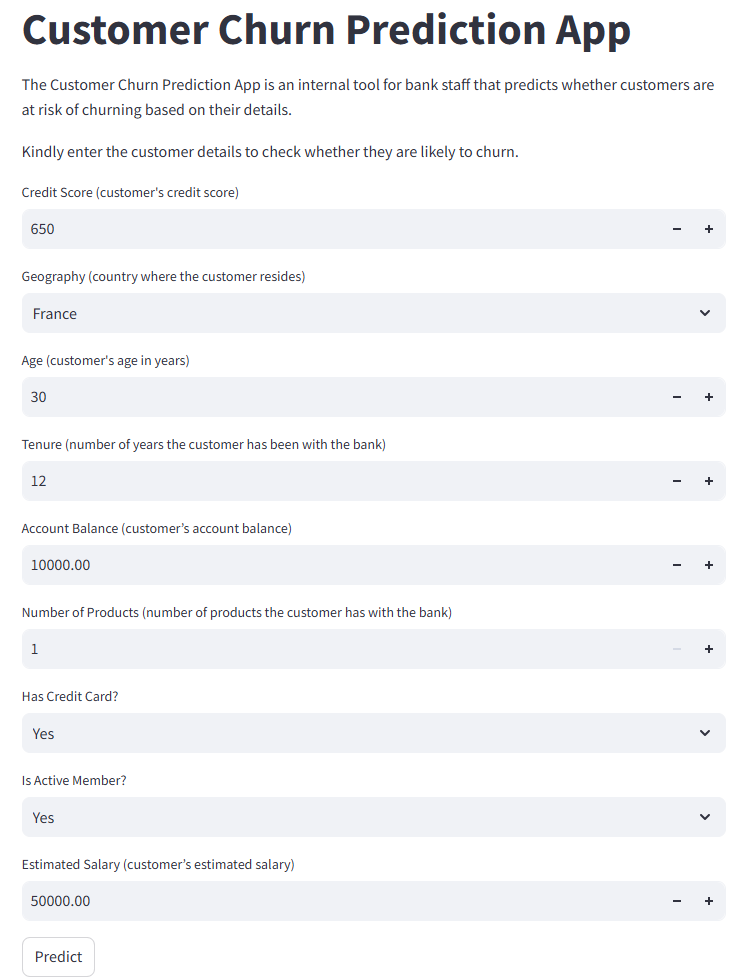

<font size=6 color="blue">Power Ahead!</font>
___